<a href="https://colab.research.google.com/github/vishalraut88/TimeSeriesForecasting_EnergyConsu/blob/main/Energy_consump_prophet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install prophet

In [40]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from prophet import Prophet

In [41]:
pjme= pd.read_csv("AEP_hourly.csv",index_col=[0],parse_dates=[0])
pjme=pjme.rename(columns={"AEP_MW":"PJME_MW"})

<Axes: xlabel='Datetime'>

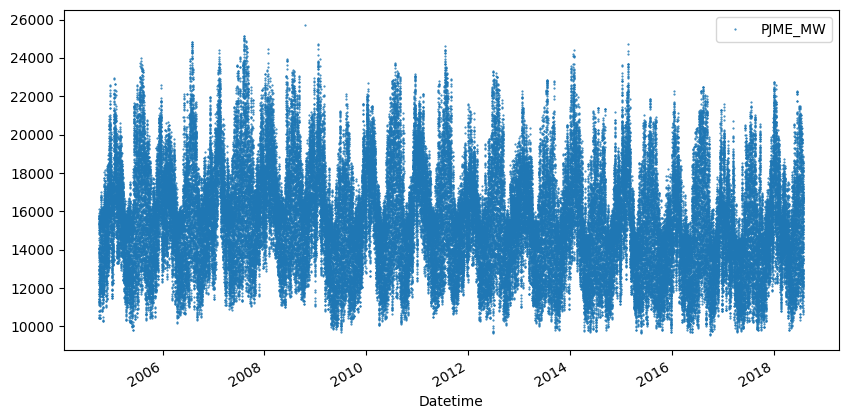

In [42]:

import matplotlib.pyplot as plt

pjme.plot(style='.',figsize=(10,5),ms=1)


# pjme.plot(style='.',
#           figsize=(10, 5),
#           ms=1,
#           color=color_pal[0],
#           title='PJME MW')

In [43]:
from pandas.api.types import CategoricalDtype

cat_type = CategoricalDtype(categories=['Monday','Tuesday',
                                        'Wednesday',
                                        'Thursday','Friday',
                                        'Saturday','Sunday'],
                            ordered=True)

def create_features(df, label=None):
    """
    Creates time series features from datetime index.
    """
    df = df.copy()
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['weekday'] = df['date'].dt.day_name()
    df['weekday'] = df['weekday'].astype(cat_type)
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    df['date_offset'] = (df.date.dt.month*100 + df.date.dt.day - 320)%1300

    df['season'] = pd.cut(df['date_offset'], [0, 300, 602, 900, 1300],
                          labels=['Spring', 'Summer', 'Fall', 'Winter']
                   )
    X = df[['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear','weekday',
           'season']]
    if label:
        y = df[label]
        return X, y
    return X

X, y = create_features(pjme, label='PJME_MW')
features_and_target = pd.concat([X, y], axis=1)

<ipython-input-43-89392304e845>:24: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df['weekofyear'] = df['date'].dt.weekofyear


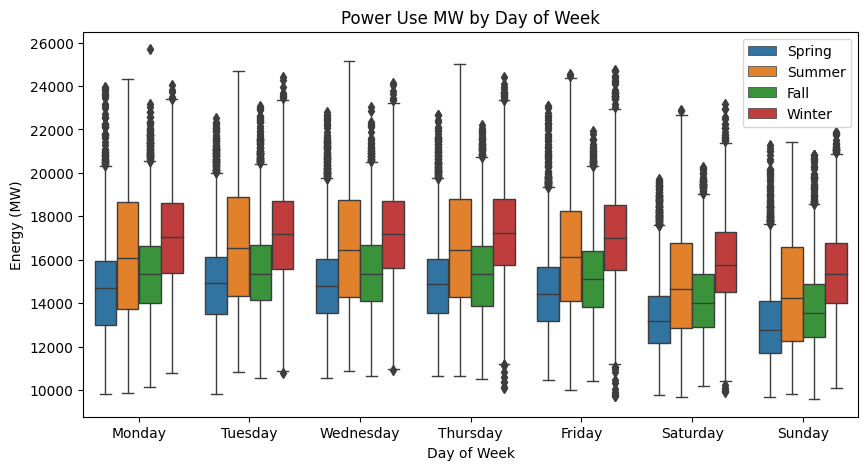

In [44]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.boxplot(data=features_and_target.dropna(),
            x='weekday',
            y='PJME_MW',
            hue='season',
            ax=ax,
            linewidth=1)
ax.set_title('Power Use MW by Day of Week')
ax.set_xlabel('Day of Week')
ax.set_ylabel('Energy (MW)')
ax.legend(bbox_to_anchor=(1, 1))
plt.show()

In [46]:
split_date = "1-Jan-2015"
pjme_train=pjme.loc[pjme.index<=split_date].copy()
pjme_test=pjme.loc[pjme.index>split_date].copy()


<Axes: xlabel='Datetime'>

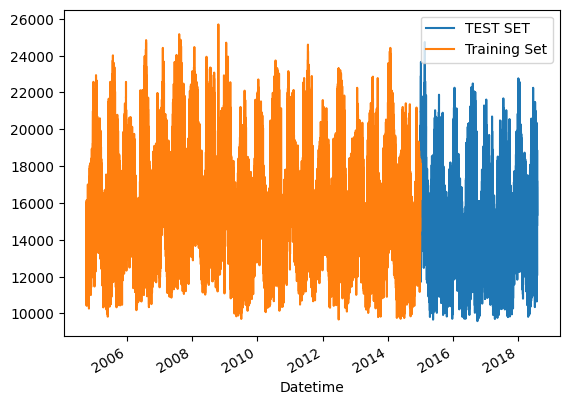

In [54]:
pjme_test.rename(columns={'PJME_MW':'TEST SET'}).join(pjme_train.rename(columns={'PJME_MW':'Training Set'}),how='outer').plot()

In [58]:
pjme_train_prophet = pjme_train.reset_index().rename(columns={'Datetime':'ds','PJME_MW':'y'})

In [59]:
pjme_train_prophet

,ds,y
0,2004-12-31 01:00:00,13478.0
1,2004-12-31 02:00:00,12865.0
2,2004-12-31 03:00:00,12577.0
3,2004-12-31 04:00:00,12517.0
4,2004-12-31 05:00:00,12670.0
...,...,...
89829,2014-01-01 20:00:00,16433.0
89830,2014-01-01 21:00:00,16376.0
89831,2014-01-01 22:00:00,16151.0
89832,2014-01-01 23:00:00,15687.0


In [60]:
model = Prophet()
model.fit(pjme_train_prophet)

DEBUG:cmdstanpy:input tempfile: /tmp/tmpseoipl4u/lb2hjgyc.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpseoipl4u/i31mo86t.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=88815', 'data', 'file=/tmp/tmpseoipl4u/lb2hjgyc.json', 'init=/tmp/tmpseoipl4u/i31mo86t.json', 'output', 'file=/tmp/tmpseoipl4u/prophet_model29mziwvs/prophet_model-20230630104120.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:41:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:42:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [61]:
pjme_test_prophet = pjme_test.reset_index().rename(columns={'Datetime':'ds','PJME_MW':'y'})

In [62]:
pjme_test_fcst = model.predict(pjme_test_prophet)

In [63]:
pjme_test_fcst.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2015-01-01 01:00:00,15023.793158,12937.328440,16583.106640,15023.793158,15023.793158,-312.769964,-312.769964,-312.769964,-1526.620451,-1526.620451,-1526.620451,601.302509,601.302509,601.302509,612.547978,612.547978,612.547978,0.0,0.0,0.0,14711.023194
1,2015-01-01 02:00:00,15023.777642,12063.986865,16076.717518,15023.777642,15023.777642,-907.462992,-907.462992,-907.462992,-2123.358856,-2123.358856,-2123.358856,602.290523,602.290523,602.290523,613.605341,613.605341,613.605341,0.0,0.0,0.0,14116.314650
2,2015-01-01 03:00:00,15023.762126,11839.567416,15556.928868,15023.762126,15023.762126,-1248.643276,-1248.643276,-1248.643276,-2465.925587,-2465.925587,-2465.925587,602.592167,602.592167,602.592167,614.690144,614.690144,614.690144,0.0,0.0,0.0,13775.118850
3,2015-01-01 04:00:00,15023.746611,11832.928056,15646.151075,15023.746611,15023.746611,-1286.879680,-1286.879680,-1286.879680,-2504.896248,-2504.896248,-2504.896248,602.214183,602.214183,602.214183,615.802385,615.802385,615.802385,0.0,0.0,0.0,13736.866931
4,2015-01-01 05:00:00,15023.731095,12162.153550,15908.128951,15023.731095,15023.731095,-990.024269,-990.024269,-990.024269,-2208.137674,-2208.137674,-2208.137674,601.171348,601.171348,601.171348,616.942057,616.942057,616.942057,0.0,0.0,0.0,14033.706826


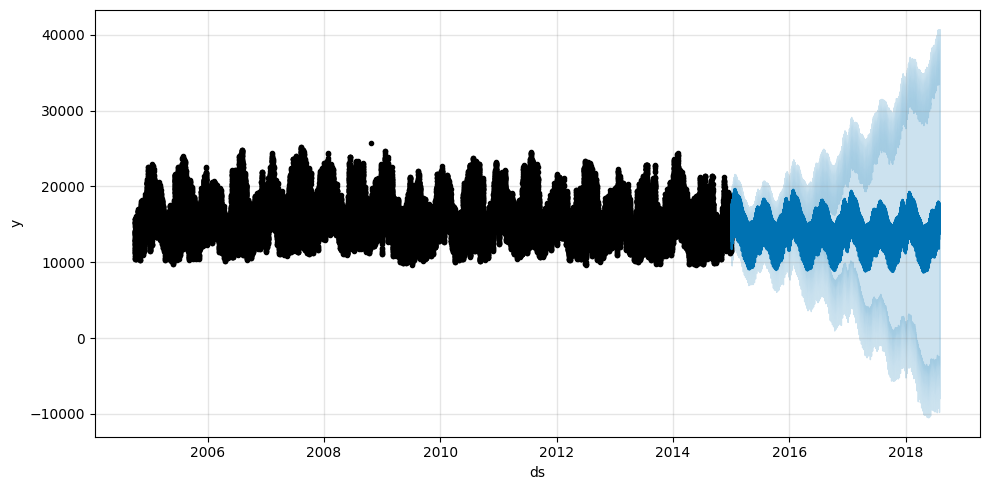

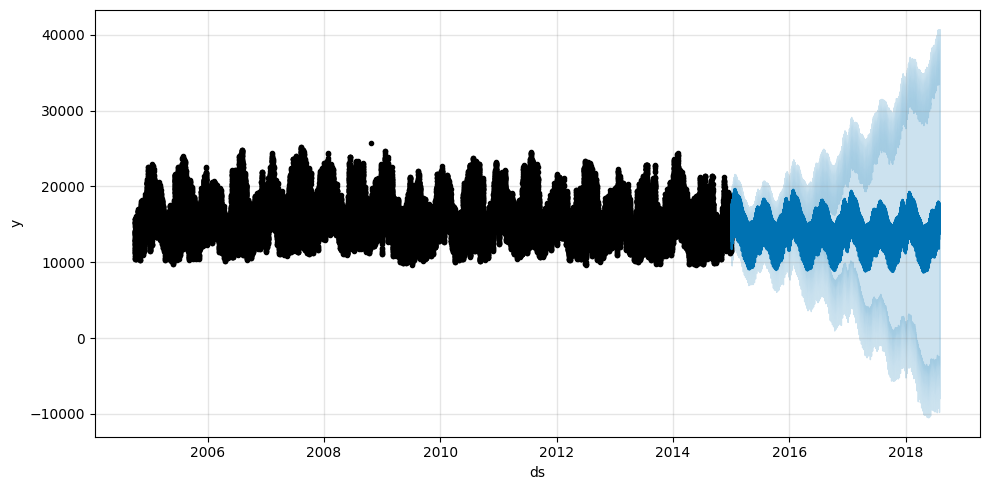

In [66]:
fig, ax = plt.subplots(figsize=(10, 5))
model.plot(pjme_test_fcst,ax=ax)

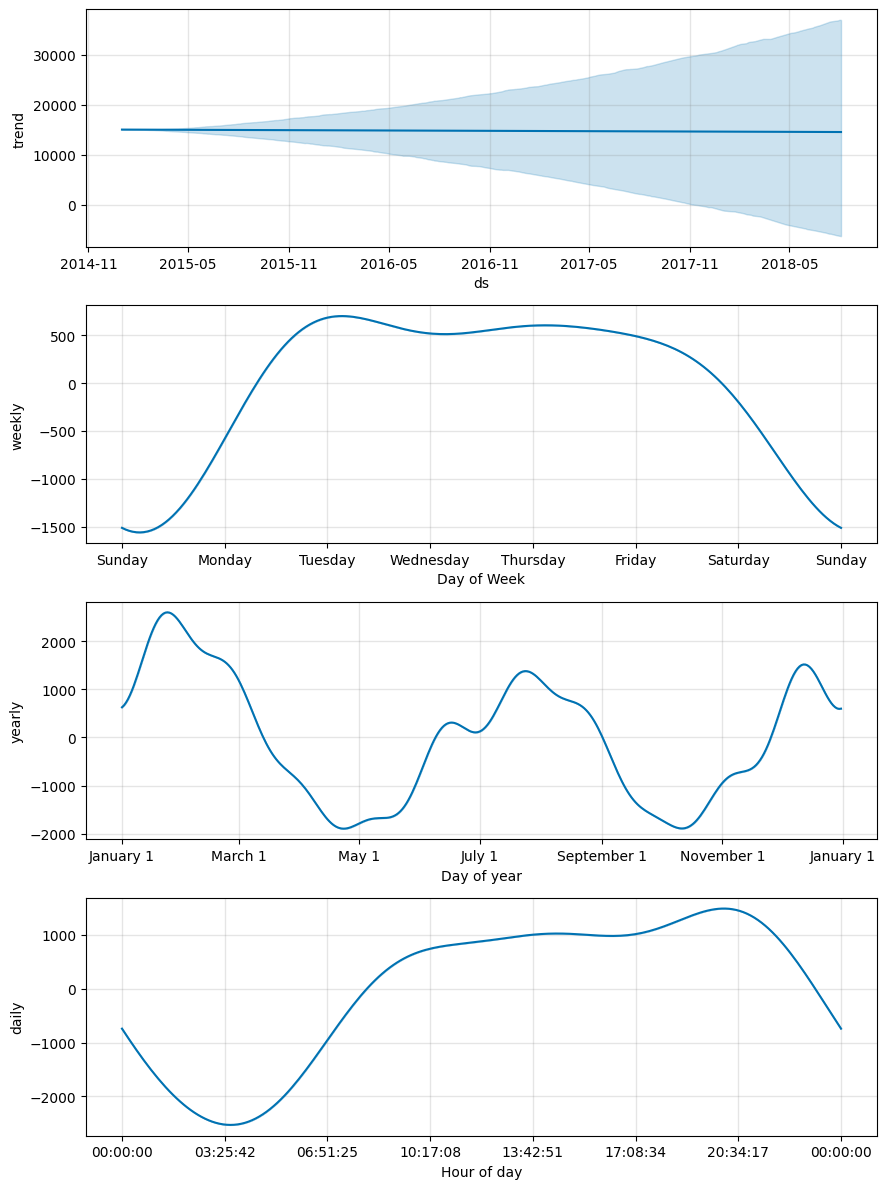

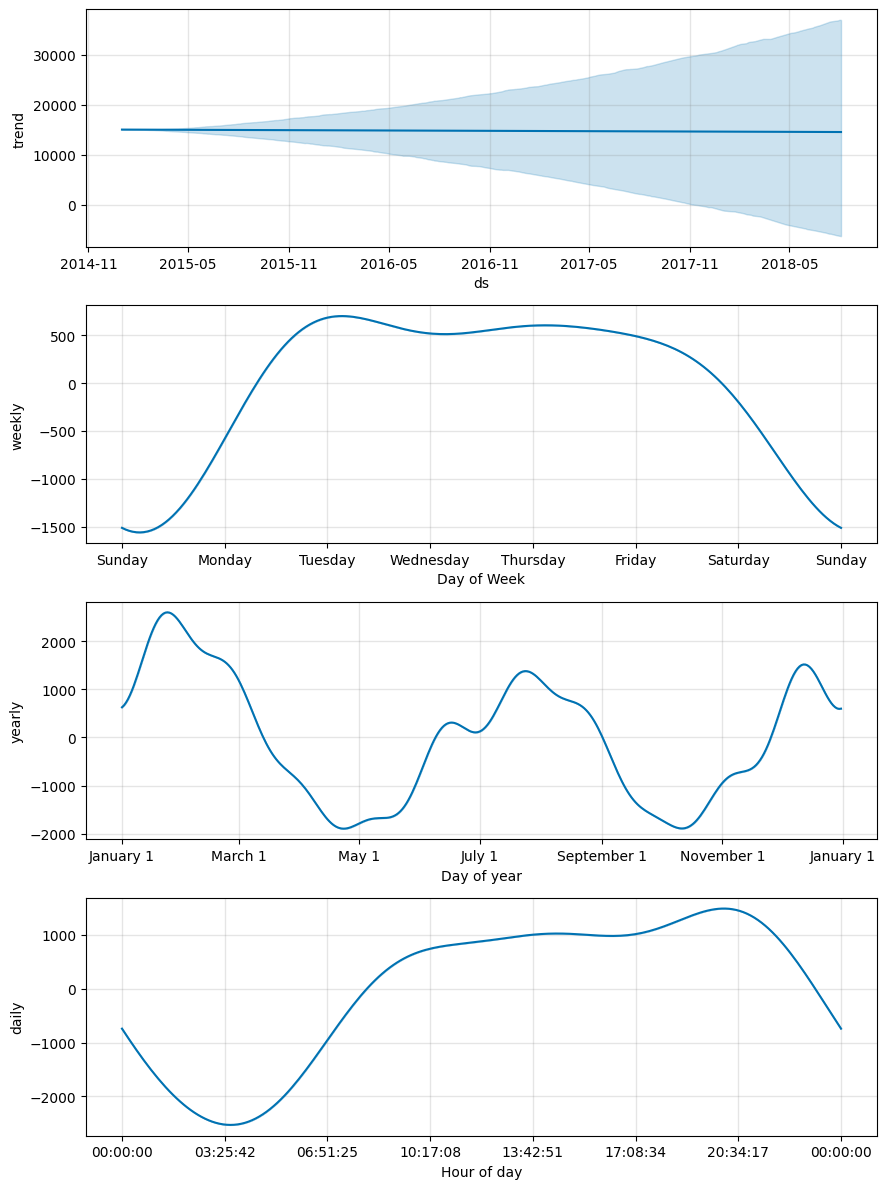

In [67]:
model.plot_components(pjme_test_fcst)

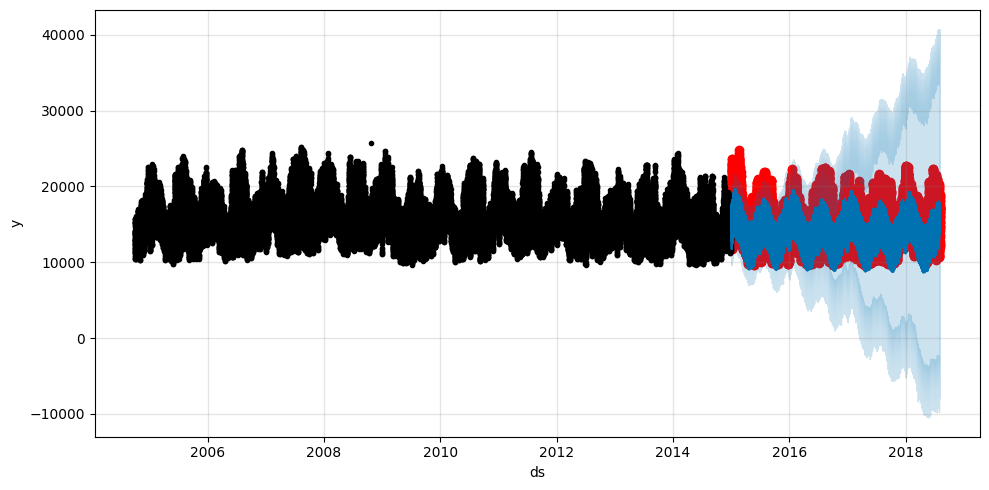

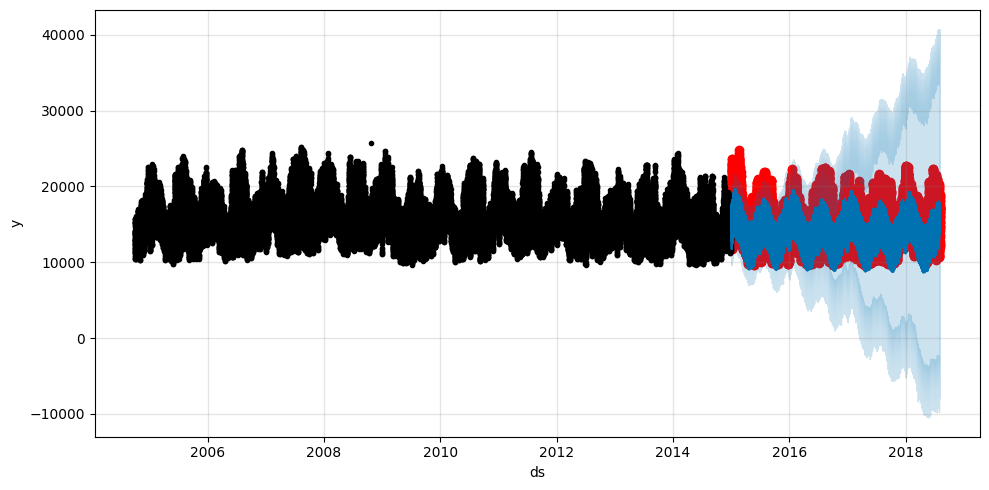

In [70]:
f,ax=plt.subplots(figsize=(10,5))
ax.scatter(pjme_test.index,pjme_test['PJME_MW'],color="r")
model.plot(pjme_test_fcst,ax=ax)

In [71]:
from sklearn.metrics import mean_squared_error,mean_absolute_error

In [72]:
np.sqrt(mean_squared_error(pjme_test['PJME_MW'],pjme_test_fcst['yhat']))

2604.8624731096984

In [73]:
mean_absolute_error(pjme_test['PJME_MW'],pjme_test_fcst['yhat'])

2082.053704819176

In [75]:

def mean_absolute_percentage_error(y_true, y_pred):
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mean_absolute_percentage_error(pjme_test['PJME_MW'],pjme_test_fcst['yhat'])

14.182559311237156

In [77]:
future = model.make_future_dataframe(periods=2*24,freq="h",include_history=False)
model.predict(future)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2015-01-01 01:00:00,15023.793158,12803.542532,16627.550885,15023.793158,15023.793158,-312.769964,-312.769964,-312.769964,-1526.620451,-1526.620451,-1526.620451,601.302509,601.302509,601.302509,612.547978,612.547978,612.547978,0.0,0.0,0.0,14711.023194
1,2015-01-01 02:00:00,15023.777642,12106.695504,16096.574458,15023.777642,15023.777642,-907.462992,-907.462992,-907.462992,-2123.358856,-2123.358856,-2123.358856,602.290523,602.290523,602.290523,613.605341,613.605341,613.605341,0.0,0.0,0.0,14116.314650
2,2015-01-01 03:00:00,15023.762126,11810.778471,15744.355316,15023.762126,15023.762126,-1248.643276,-1248.643276,-1248.643276,-2465.925587,-2465.925587,-2465.925587,602.592167,602.592167,602.592167,614.690144,614.690144,614.690144,0.0,0.0,0.0,13775.118850
3,2015-01-01 04:00:00,15023.746611,11675.618998,15699.301288,15023.746611,15023.746611,-1286.879680,-1286.879680,-1286.879680,-2504.896248,-2504.896248,-2504.896248,602.214183,602.214183,602.214183,615.802385,615.802385,615.802385,0.0,0.0,0.0,13736.866931
4,2015-01-01 05:00:00,15023.731095,12216.449570,15879.712980,15023.731095,15023.731095,-990.024269,-990.024269,-990.024269,-2208.137674,-2208.137674,-2208.137674,601.171348,601.171348,601.171348,616.942057,616.942057,616.942057,0.0,0.0,0.0,14033.706826
5,2015-01-01 06:00:00,15023.715579,12746.246553,16489.068618,15023.715579,15023.715579,-391.013691,-391.013691,-391.013691,-1608.608238,-1608.608238,-1608.608238,599.485392,599.485392,599.485392,618.109156,618.109156,618.109156,0.0,0.0,0.0,14632.701889
6,2015-01-01 07:00:00,15023.700064,13443.341033,17364.734697,15023.700064,15023.700064,374.990641,374.990641,374.990641,-841.496830,-841.496830,-841.496830,597.183798,597.183798,597.183798,619.303673,619.303673,619.303673,0.0,0.0,0.0,15398.690705
7,2015-01-01 08:00:00,15023.684548,14175.453429,18158.378098,15023.684548,15023.684548,1105.452233,1105.452233,1105.452233,-109.371848,-109.371848,-109.371848,594.298480,594.298480,594.298480,620.525601,620.525601,620.525601,0.0,0.0,0.0,16129.136782
8,2015-01-01 09:00:00,15023.669033,14668.417257,18549.163008,15023.669033,15023.669033,1631.752450,1631.752450,1631.752450,419.113136,419.113136,419.113136,590.864384,590.864384,590.864384,621.774931,621.774931,621.774931,0.0,0.0,0.0,16655.421483
9,2015-01-01 10:00:00,15023.653517,14878.723100,18799.506009,15023.653517,15023.653517,1909.656192,1909.656192,1909.656192,699.686526,699.686526,699.686526,586.918014,586.918014,586.918014,623.051652,623.051652,623.051652,0.0,0.0,0.0,16933.309709
